In [97]:
# Add imports here
!pip install imbalanced-learn


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

Data: https://huggingface.co/datasets/KodeCharya/The_California_Wildfire_Data

Resources:
- https://www.geeksforgeeks.org/machine-learning/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NeighborhoodComponentsAnalysis.html
- https://www.geeksforgeeks.org/machine-learning/naive-bayes-classifiers/
- https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html


In [99]:
# Loading and "cleaning" data
df = pd.read_csv("California-Wildfire-Data.csv")
df_obj = df.select_dtypes("object")

df_obj.head()

C:\Users\Advait\AppData\Local\Temp\ipykernel_19732\1426229991.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("California-Wildfire-Data.csv")


,* Damage,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)",* City,State,* CAL FIRE Unit,County,* Incident Name,Incident Number (e.g. CAAEU 123456),Incident Start Date,...,* Vent Screen,* Exterior Siding,* Window Pane,* Deck/Porch On Grade,* Deck/Porch Elevated,* Patio Cover/Carport Attached to Structure,* Fence Attached to Structure,APN (parcel),Site Address (parcel),GLOBALID
0,Destroyed (>50%),unknown,Road,NaN,CA,FKU,Fresno,Creek,CAFKU 013369,09-04-2020 00:00,...,"Mesh Screen <= 1/8""""",Wood,Single Pane,No Deck/Porch,No Deck/Porch,No Patio Cover/Carport,No Fence,11616045,NaN,ce752f2c-dea2-4647-b0cd-e4ed01f8619d
1,Destroyed (>50%),unknown,Road,NaN,CA,FKU,Fresno,Creek,CAFKU 013369,09-04-2020 00:00,...,"Mesh Screen <= 1/8""""",Wood,Single Pane,Wood,No Deck/Porch,No Patio Cover/Carport,No Fence,11616015,NaN,1ddec00c-ab14-477a-a48d-cd86379d6883
2,No Damage,unknown,NaN,NaN,CA,FKU,Fresno,Creek,CAFKU 013369,09-04-2020 00:00,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,others,11616045,NaN,cf41a0c1-8150-4052-96cf-60a97076033c
3,Destroyed (>50%),unknown,NaN,NaN,CA,FKU,Fresno,Creek,CAFKU 013369,09-04-2020 00:00,...,Unknown,Wood,Multi Pane,Wood,No Deck/Porch,No Patio Cover/Carport,No Fence,11616061,NaN,d6664da1-7df2-402c-8927-bbd2f845f1de
4,Destroyed (>50%),unknown,NaN,NaN,CA,FKU,Fresno,Creek,CAFKU 013369,09-04-2020 00:00,...,No Vents,Stucco Brick Cement,Multi Pane,No Deck/Porch,No Deck/Porch,No Patio Cover/Carport,No Fence,11616061,NaN,cba02c94-02f9-4a24-a22c-d34ab2b49588


In [100]:
# Numeric data
df_num = df.select_dtypes("number")

df_num["* Street Number"] = df_num["* Street Number"].replace(to_replace=0, value=np.nan)
print(f"Missing values in Street Number: {df_num['* Street Number'].isna().sum()}")
df_num["Assessed Improved Value (parcel)"] = df_num["Assessed Improved Value (parcel)"].replace(to_replace=0, value=np.nan)
print(f"Missing values in Assessed Improved Value (parcel): {df_num['Assessed Improved Value (parcel)'].isna().sum()}")

df_num["Year Built (parcel)"] = df_num["Year Built (parcel)"].replace(to_replace=0, value=np.nan)
print(f"Missing values in Year Built (parcel): {df_num['Year Built (parcel)'].isna().sum()}")

#df_num = df_num.dropna()
#print(f"Rows remaining after dropping na: {len(df_num.index)}")

df_num.head()

Missing values in Street Number: 2606
Missing values in Assessed Improved Value (parcel): 3208
Missing values in Year Built (parcel): 6731


,_id,* Street Number,Assessed Improved Value (parcel),Year Built (parcel),Latitude,Longitude,x,y
0,6092,NaN,NaN,NaN,37.111043,-119.423521,-13294165.60,4454596.026
1,6094,NaN,NaN,NaN,37.106640,-119.422092,-13294006.50,4453981.424
2,6165,NaN,NaN,NaN,37.111133,-119.423931,-13294211.18,4454608.627
3,6171,NaN,NaN,NaN,37.108730,-119.418960,-13293657.81,4454273.178
4,6172,NaN,NaN,NaN,37.108870,-119.418843,-13293644.77,4454292.743


# Exploritory Data Analysis

In [101]:
# Exploratory Data Analysis
for col in df_obj.columns:
    unique_vals = df_obj[col].unique()
    n_unique = len(unique_vals)
    print(f"\n{col}:")
    print(f"Number of unique values: {n_unique}")
    if "unknown" in list(unique_vals):
        print(f"Number of missing values: {0 + df_obj[col].value_counts()['unknown']}")
    if "Unknown" in list(unique_vals):
        print(f"Number of missing values: {0 + df_obj[col].value_counts()['Unknown']}")
    if n_unique <= 20:
        print(f"Values: {list(unique_vals)}")
    else:
        print(f"Sample values (first 20): {list(unique_vals[:20])}")


* Damage:
Number of unique values: 6
Values: ['Destroyed (>50%)', 'No Damage', 'Minor (10-25%)', 'Affected (1-9%)', 'Major (26-50%)', 'Inaccessible']

* Street Name:
Number of unique values: 4354
Number of missing values: 63
Sample values (first 20): ['unknown', 'Mammoth', 'Sunset Rock', 'Minaret', 'Meadow North', 'North Meadow', 'Minarets', 'Mammoth Falls', 'Mammoth Pool', '4S81', 'Tamarack', 'Pine Cone Path', 'Beasore', 'North Silvertip', 'Meadow', 'Jose Basin', 'Sugarloaf Road', 'Kinsman Flat', 'Arrowhead', 'Point']

* Street Type (e.g. road, drive, lane, etc.):
Number of unique values: 19
Values: ['Road', nan, 'Lane', 'Trail', 'Way', 'Other', 'Drive', 'Circle', 'Place', 'Court', 'Loop', 'Route', 'Parkway', 'Terrace', 'Street', 'Avenue', 'Boulevard', 'Alley', 'Hwy']

* City:
Number of unique values: 213
Number of missing values: 1
Sample values (first 20): [nan, 'Los Angeles', 'LANCASTER', 'Gorman', 'Llano', 'Malibu', 'Pismo Beach', 'Browns Valley', 'Unincorporated', 'Potrero', 'Ch

In [102]:
for col in df_num.columns:
    print(f"\n{col}:")
    print(f"Mean: {df_num[col].mean():.2f}")
    print(f"Median: {df_num[col].median():.2f}")
    mode_vals = df_num[col].mode()
    if len(mode_vals) > 0:
        print(f"Mode: {mode_vals[0]:.2f}")
    else:
        print(f"Mode: N/A")
    print(f"Std Dev: {df_num[col].std():.2f}")
    print(f"Min: {df_num[col].min():.2f}")
    print(f"Max: {df_num[col].max():.2f}")


_id:
Mean: 40070.61
Median: 34504.50
Mode: 1.00
Std Dev: 29739.40
Min: 1.00
Max: 100230.00

* Street Number:
Mean: 37972.76
Median: 5501.00
Mode: 580.00
Std Dev: 6116971.87
Min: 1.00
Max: 1410065407.00

Assessed Improved Value (parcel):
Mean: 826885.65
Median: 159480.00
Mode: 54139901.00
Std Dev: 7729184.52
Min: 100.00
Max: 393602009.00

Year Built (parcel):
Mean: 1971.85
Median: 1976.00
Mode: 1979.00
Std Dev: 30.96
Min: 1.00
Max: 2022.00

Latitude:
Mean: 38.17
Median: 38.69
Mode: 39.75
Std Dev: 2.14
Min: 32.59
Max: 41.94

Longitude:
Mean: -121.03
Median: -121.60
Mode: -122.78
Std Dev: 1.57
Min: -123.45
Max: -116.62

x:
Mean: -13472711.53
Median: -13536060.62
Mode: -13534734.32
Std Dev: 175063.62
Min: -13741873.56
Max: -12982511.63

y:
Mean: 4608113.37
Median: 4678024.00
Mode: 4829244.90
Std Dev: 298730.14
Min: 3841345.56
Max: 5151260.83


# Preprocessing

In [103]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df_obj.copy()
le_target = LabelEncoder()

# Fit and save the target encoder
le_target.fit(df_obj['* Damage'].astype(str))

# Encode all columns
for col in df_encoded.columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# combine numeric and encoded categorical data, not feature selected yet
attr = pd.concat([df_encoded.drop(['* Damage'], axis=1), df_num], axis=1)
target = df_encoded['* Damage']

attr.head()

,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)",* City,State,* CAL FIRE Unit,County,* Incident Name,Incident Number (e.g. CAAEU 123456),Incident Start Date,Hazard Type,...,Site Address (parcel),GLOBALID,_id,* Street Number,Assessed Improved Value (parcel),Year Built (parcel),Latitude,Longitude,x,y
0,4351,12,211,0,5,7,38,44,61,0,...,30698,45026,6092,NaN,NaN,NaN,37.111043,-119.423521,-13294165.60,4454596.026
1,4351,12,211,0,5,7,38,44,61,0,...,30698,6566,6094,NaN,NaN,NaN,37.106640,-119.422092,-13294006.50,4453981.424
2,4351,18,211,0,5,7,38,44,61,0,...,30698,45205,6165,NaN,NaN,NaN,37.111133,-119.423931,-13294211.18,4454608.627
3,4351,18,211,0,5,7,38,44,61,0,...,30698,46702,6171,NaN,NaN,NaN,37.108730,-119.418960,-13293657.81,4454273.178
4,4351,18,211,0,5,7,38,44,61,0,...,30698,44421,6172,NaN,NaN,NaN,37.108870,-119.418843,-13293644.77,4454292.743


In [104]:
#Feature Selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(score_func=mutual_info_classif, k=15)
# optimal attributes/features
out_feats = selector.fit_transform(attr.fillna(-1), target)
opt_attr = pd.DataFrame(out_feats, columns=selector.get_feature_names_out()).dropna(axis=1)
print("Best features:", selector.get_feature_names_out())
# Split data into training and testing sets 80-20
attr_train, attr_test, target_train, target_test = train_test_split(opt_attr, target, test_size=0.2, random_state=6)


Best features: ['* Street Name' '* City' '* CAL FIRE Unit' 'County' '* Incident Name'
 'Incident Number (e.g. CAAEU 123456)' 'Incident Start Date'
 '* Exterior Siding' 'APN (parcel)' 'Site Address (parcel)' '_id'
 'Latitude' 'Longitude' 'x' 'y']


# KNN


Applying SMOTE to training data...
Training KNN with best parameters (n_neighbors=3, weights='distance')...
KNN Classification Report (with SMOTE):
                  precision    recall  f1-score   support

 Affected (1-9%)       0.12      0.26      0.16       380
Destroyed (>50%)       0.92      0.82      0.86      6102
    Inaccessible       0.25      0.62      0.36        34
  Major (26-50%)       0.01      0.04      0.02        50
  Minor (10-25%)       0.05      0.17      0.07        83
       No Damage       0.90      0.88      0.89      4501

        accuracy                           0.81     11150
       macro avg       0.37      0.46      0.39     11150
    weighted avg       0.87      0.81      0.84     11150



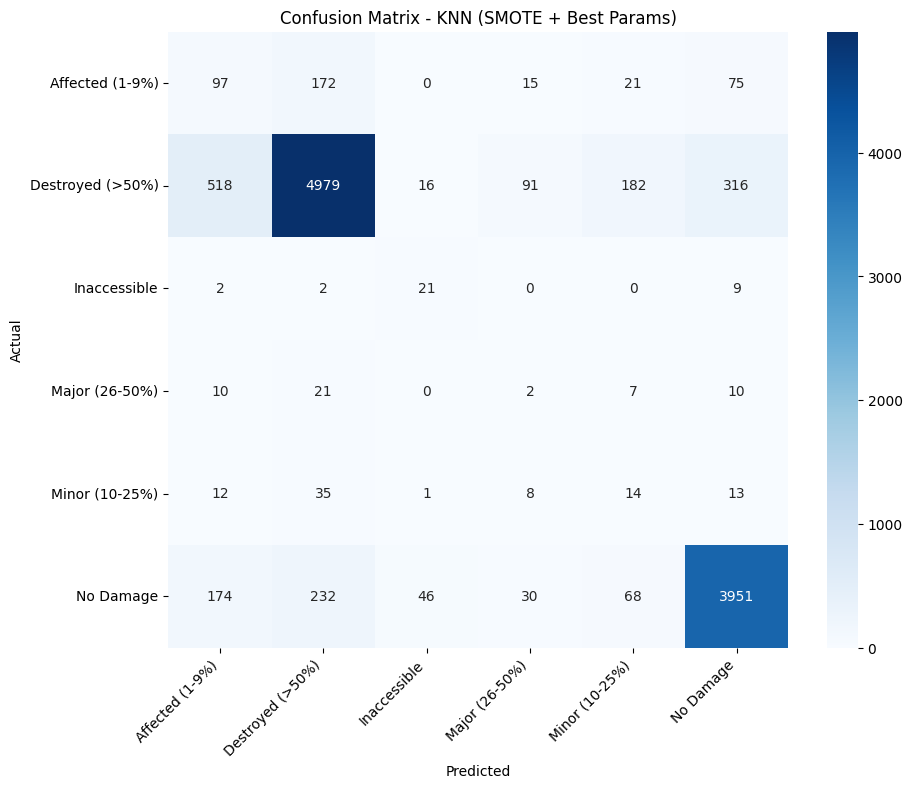

In [105]:
# KNN Implementation with SMOTE, Scaling and Best Params
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '1'

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Apply SMOTE to Training Data Only
print("Applying SMOTE to training data...")
smote = SMOTE(random_state=42)
attr_train_res, target_train_res = smote.fit_resample(attr_train, target_train)

# Round to nearest int to keep categorical nature valid
attr_train_res = np.round(attr_train_res).astype(int)

# Scaling (Fit on Resampled Training Data)
scaler = MinMaxScaler()
attr_train_scaled = scaler.fit_transform(attr_train_res)
attr_test_scaled = scaler.transform(attr_test)

# # Grid Search (Commented out as requested)
# print("Starting Grid Search for KNN...")
# param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
# grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, n_jobs=1, verbose=1)
# grid_knn.fit(attr_train_scaled, target_train_res)
# print(f"Best KNN Parameters: {grid_knn.best_params_}")
# target_pred = grid_knn.predict(attr_test_scaled)

# Using Best Parameters directly
print("Training KNN with best parameters (n_neighbors=3, weights='distance')...")
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(attr_train_scaled, target_train_res)
target_pred = knn.predict(attr_test_scaled)

# Decode for report
target_test_decoded = le_target.inverse_transform(target_test)
target_pred_decoded = le_target.inverse_transform(target_pred)
labels = le_target.classes_

# Evaluation
print("KNN Classification Report (with SMOTE):")
print(classification_report(target_test_decoded, target_pred_decoded))

# Confusion Matrix
cm = confusion_matrix(target_test_decoded, target_pred_decoded, labels=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - KNN (SMOTE + Best Params)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45, ha='right')
plt.show()

K-Nearest Neighbors (KNN) is a distance-based classifier that predicts damage by finding the most similar examples in the training set. In our case, we used SMOTE to balance the classes and `weights='distance'` to prioritize closer neighbors. Our accuracy is 81%, but we saw improved recall for minority classes compared to previous iterations. KNN is able to predict the majority classes with high accuracy, and interestingly, it can predict the “inaccessible” class—a minority class—with better accuracy than the other minority classes. While our macro scores are relavity low, our weighted scores are much higher because of the class imbalance.

# KNN With Neighborhood Component Analysis (NCA)

Training Advanced KNN with NCA...
Preparing data (re-splitting opt_attr)...
Applying SMOTE...
Subsampling data for NCA metric learning (using 10000 samples)...
Fitting NCA on subset...
Transforming full training and test data...
Training KNN on full NCA-transformed data...

Advanced KNN (NCA) Classification Report:
                  precision    recall  f1-score   support

 Affected (1-9%)       0.10      0.27      0.15       380
Destroyed (>50%)       0.91      0.78      0.84      6102
    Inaccessible       0.22      0.59      0.31        34
  Major (26-50%)       0.01      0.04      0.02        50
  Minor (10-25%)       0.03      0.13      0.05        83
       No Damage       0.90      0.85      0.88      4501

        accuracy                           0.78     11150
       macro avg       0.36      0.44      0.37     11150
    weighted avg       0.87      0.78      0.82     11150



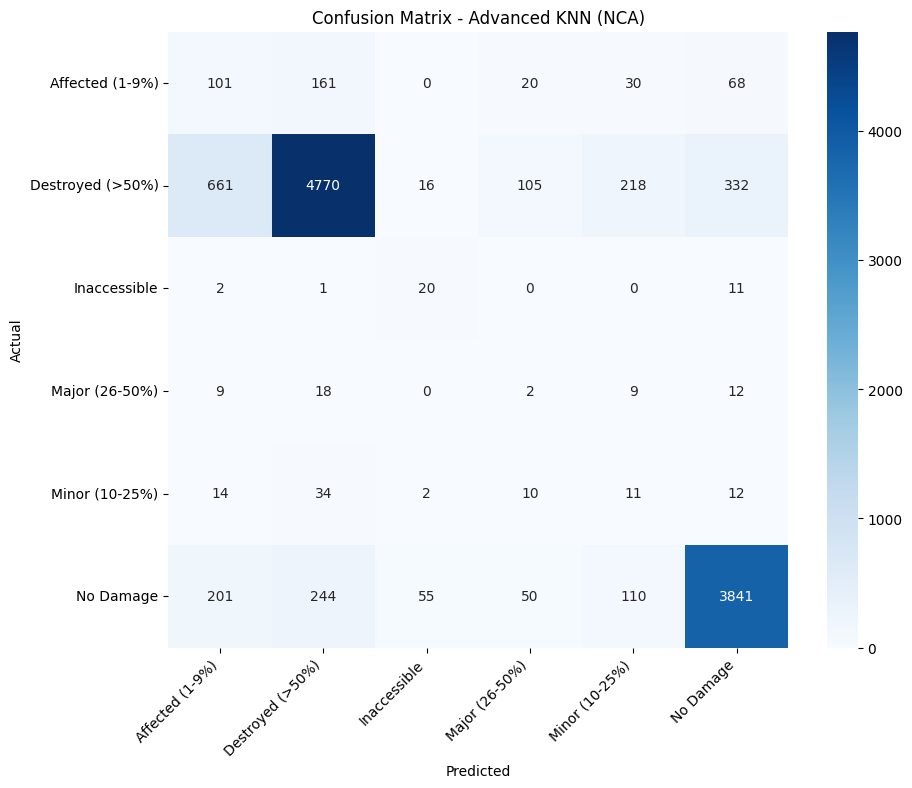

In [78]:
# Advanced Model: KNN with Neighborhood Components Analysis (NCA)
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
import numpy as np

print("Training Advanced KNN with NCA...")

# 1. Ensure we have the correct data (re-splitting to avoid variable conflicts from other cells)
# We use opt_attr which contains the selected 15 features
print("Preparing data (re-splitting opt_attr)...")
X_train, X_test, y_train, y_test = train_test_split(opt_attr, target, test_size=0.2, random_state=6)

# 2. Apply SMOTE (as done in the baseline KNN)
print("Applying SMOTE...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Round to nearest int to keep categorical nature valid (as done in baseline)
X_train_res = np.round(X_train_res).astype(int)

# 3. Subsample for NCA metric learning (Optimization)
subset_size = 10000
if len(X_train_res) > subset_size:
    print(f"Subsampling data for NCA metric learning (using {subset_size} samples)...")
    X_nca_train, y_nca_train = shuffle(X_train_res, y_train_res, random_state=42, n_samples=subset_size)
else:
    X_nca_train, y_nca_train = X_train_res, y_train_res

# 4. Define and Fit NCA
scaler = StandardScaler()
nca = NeighborhoodComponentsAnalysis(random_state=42)

# Scale and fit NCA on subset
print("Fitting NCA on subset...")
X_nca_train_scaled = scaler.fit_transform(X_nca_train)
nca.fit(X_nca_train_scaled, y_nca_train)

# 5. Transform Full Data
print("Transforming full training and test data...")
# Note: Use the full resampled training set for the final KNN
X_train_res_scaled = scaler.transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

X_train_nca = nca.transform(X_train_res_scaled)
X_test_nca = nca.transform(X_test_scaled)

# 6. Train KNN on Full Transformed Data
print("Training KNN on full NCA-transformed data...")
knn_nca = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn_nca.fit(X_train_nca, y_train_res)

# Predict
target_pred_nca = knn_nca.predict(X_test_nca)

# Decode for report
target_test_decoded_nca = le_target.inverse_transform(y_test)
target_pred_decoded_nca = le_target.inverse_transform(target_pred_nca)

# Evaluation
print("\nAdvanced KNN (NCA) Classification Report:")
print(classification_report(target_test_decoded_nca, target_pred_decoded_nca))

# Confusion Matrix
cm_nca = confusion_matrix(target_test_decoded_nca, target_pred_decoded_nca, labels=le_target.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_nca, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title('Confusion Matrix - Advanced KNN (NCA)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45, ha='right')
plt.show()

On top of using SMOTE, we also used neighborhood components analysis (NCA) to transform the data before training the KNN model. While we hoped it would improve performance, it did not. In many cases, it even worsened performance, its possible the number of samples was too small for NCA to be effective, but the cost and time it took to run NCA may not be worth the small increase in performance. 

# CART

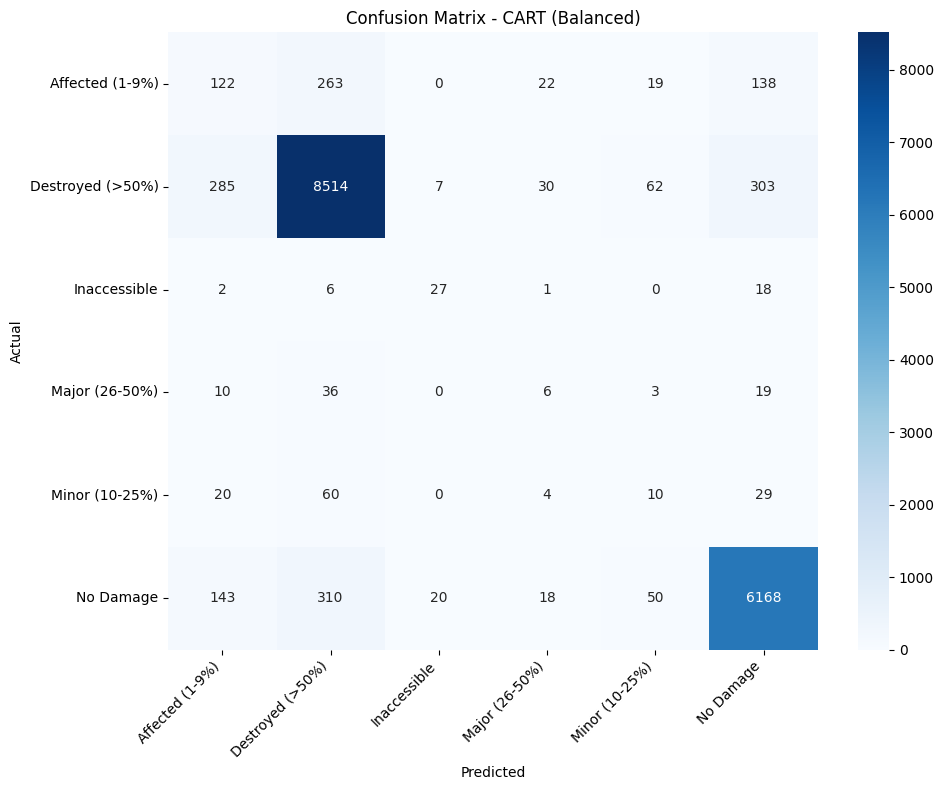

                  precision    recall  f1-score   support

 Affected (1-9%)       0.21      0.22      0.21       564
Destroyed (>50%)       0.93      0.93      0.93      9201
    Inaccessible       0.50      0.50      0.50        54
  Major (26-50%)       0.07      0.08      0.08        74
  Minor (10-25%)       0.07      0.08      0.07       123
       No Damage       0.92      0.92      0.92      6709

        accuracy                           0.89     16725
       macro avg       0.45      0.45      0.45     16725
    weighted avg       0.89      0.89      0.89     16725



In [79]:
# Using a label encoder here because using the get_dummies() method takes too much memory and crashes the kernel.
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


df_encoded = opt_attr.copy()
le_target = LabelEncoder()

# Fit and save the target encoder
le_target.fit(df_obj['* Damage'].astype(str))


# Encode all columns
for col in df_encoded.columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# attr = df_encoded.drop(['* Damage'], axis=1)
# target = df_encoded['* Damage']

attr_train, attr_test, target_train, target_test = train_test_split(attr, target, test_size=0.3, random_state=6)

# Added class_weight='balanced' to handle class imbalance
model = DecisionTreeClassifier()
model.fit(attr_train, target_train)
target_pred = model.predict(attr_test)

# Decode predictions and targets
target_test_decoded = le_target.inverse_transform(target_test)
target_pred_decoded = le_target.inverse_transform(target_pred)

# Get class labels
labels = le_target.classes_

# Create confusion matrix
cm = confusion_matrix(target_test_decoded, target_pred_decoded, labels=labels)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CART (Balanced)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(classification_report(target_test_decoded, target_pred_decoded))

Using the CART method, we see that our model is 89% accurate. We can also see that most of our data either falls into "No Damage" or "Destroyed". There is significantly less data for any other categories.

# Naive Bayes


Training CategoricalNB with best parameters (alpha=0.01)...

Naive Bayes Classification Report:
                  precision    recall  f1-score   support

 Affected (1-9%)       0.14      0.18      0.16       380
Destroyed (>50%)       0.94      0.75      0.84      6102
    Inaccessible       0.07      0.71      0.13        34
  Major (26-50%)       0.03      0.24      0.05        50
  Minor (10-25%)       0.04      0.13      0.07        83
       No Damage       0.80      0.86      0.83      4501

        accuracy                           0.77     11150
       macro avg       0.34      0.48      0.35     11150
    weighted avg       0.85      0.77      0.80     11150



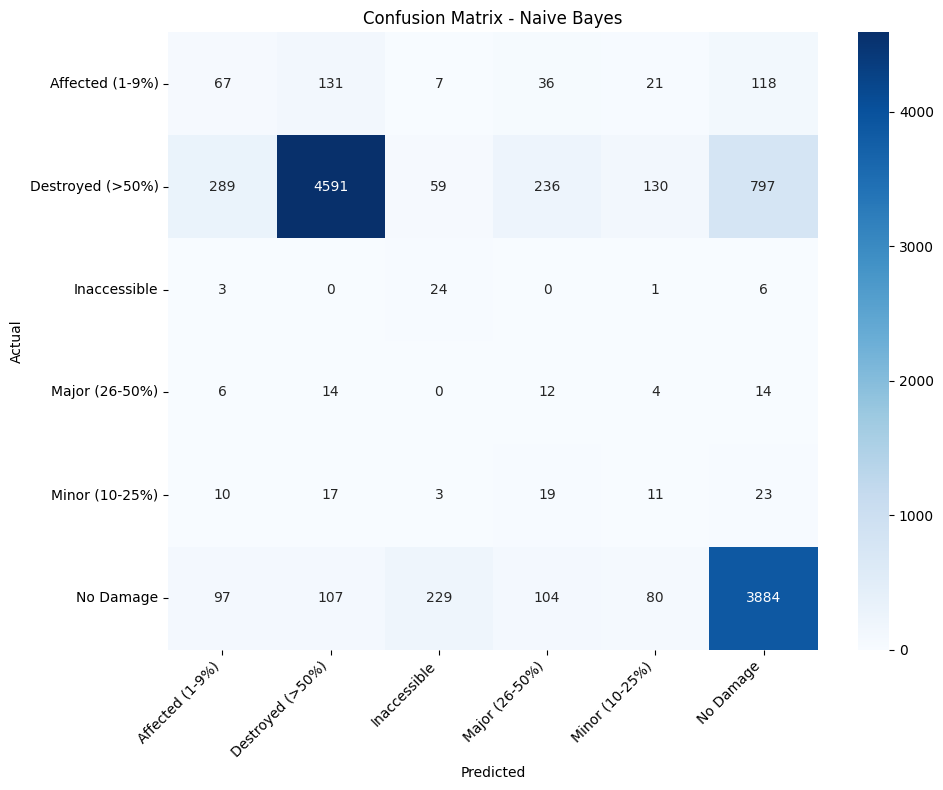

In [80]:
# Naive Bayes Implementation (with best parameters from tuning)
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split  # , GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. Encode the data (similar to CART approach)
# Use LabelEncoder on each column to convert to non-negative integers
df_encoded_nb = opt_attr.copy()

for col in df_encoded_nb.columns:
    le = LabelEncoder()
    df_encoded_nb[col] = le.fit_transform(df_encoded_nb[col].astype(str))

# 2. Split Data (80-20 split)
attr_train_nb, attr_test_nb, target_train_nb, target_test_nb = train_test_split(
    df_encoded_nb, target, test_size=0.2, random_state=6
)

# 3. Compute sample weights for class balancing
sample_weights = compute_sample_weight(class_weight='balanced', y=target_train_nb)

# 4. Calculate min_categories from the full encoded dataset
min_categories = [int(df_encoded_nb[col].max() + 1) for col in df_encoded_nb.columns]

# # 5. Hyperparameter Tuning with GridSearchCV (COMMENTED OUT - using best params below)
# print("Performing hyperparameter tuning for CategoricalNB...")
# param_grid = {
#     'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
# }
# 
# nb_base = CategoricalNB(min_categories=min_categories)
# grid_search = GridSearchCV(
#     nb_base, 
#     param_grid, 
#     cv=5, 
#     scoring='accuracy',
#     n_jobs=-1,
#     verbose=1
# )
# 
# grid_search.fit(attr_train_nb, target_train_nb, sample_weight=sample_weights)
# 
# print(f"\nBest parameters: {grid_search.best_params_}")
# print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
# 
# nb = grid_search.best_estimator_

# 5. Train model with best parameters (from grid search: alpha=1.0)
print("Training CategoricalNB with best parameters (alpha=0.01)...")
nb = CategoricalNB(alpha=0.01, min_categories=min_categories)
nb.fit(attr_train_nb, target_train_nb, sample_weight=sample_weights)

# 6. Predict
target_pred_nb = nb.predict(attr_test_nb)

# 7. Evaluate
# Decode targets for readable report
target_test_decoded = le_target.inverse_transform(target_test_nb)
target_pred_decoded = le_target.inverse_transform(target_pred_nb)

print("\nNaive Bayes Classification Report:")
print(classification_report(target_test_decoded, target_pred_decoded))

# Confusion Matrix
cm_nb = confusion_matrix(target_test_decoded, target_pred_decoded, labels=le_target.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Naive Bayes is a probabilistic classifier based on Bayes’ theorem; we use `CategoricalNB` since it fits our labeled data, and we apply `class_weight='balanced'` to help with detecting minority damage categories. Our accuracy is 77%, but we saw improved recall for minority classes. It did surprisingly well on the “inaccessible” class, but it struggled with the “major” and “minor” damage classes. Its overall accuracy is lower than our KNN, but for a model that only uses categorical features, it performed surprisingly well.

# Decision Trees


Decision Trees Classification Report:
                  precision    recall  f1-score   support

 Affected (1-9%)       0.12      0.36      0.18       380
Destroyed (>50%)       0.98      0.72      0.83      6102
    Inaccessible       0.16      0.65      0.26        34
  Major (26-50%)       0.03      0.36      0.05        50
  Minor (10-25%)       0.02      0.14      0.04        83
       No Damage       0.90      0.83      0.86      4501

        accuracy                           0.75     11150
       macro avg       0.37      0.51      0.37     11150
    weighted avg       0.90      0.75      0.81     11150



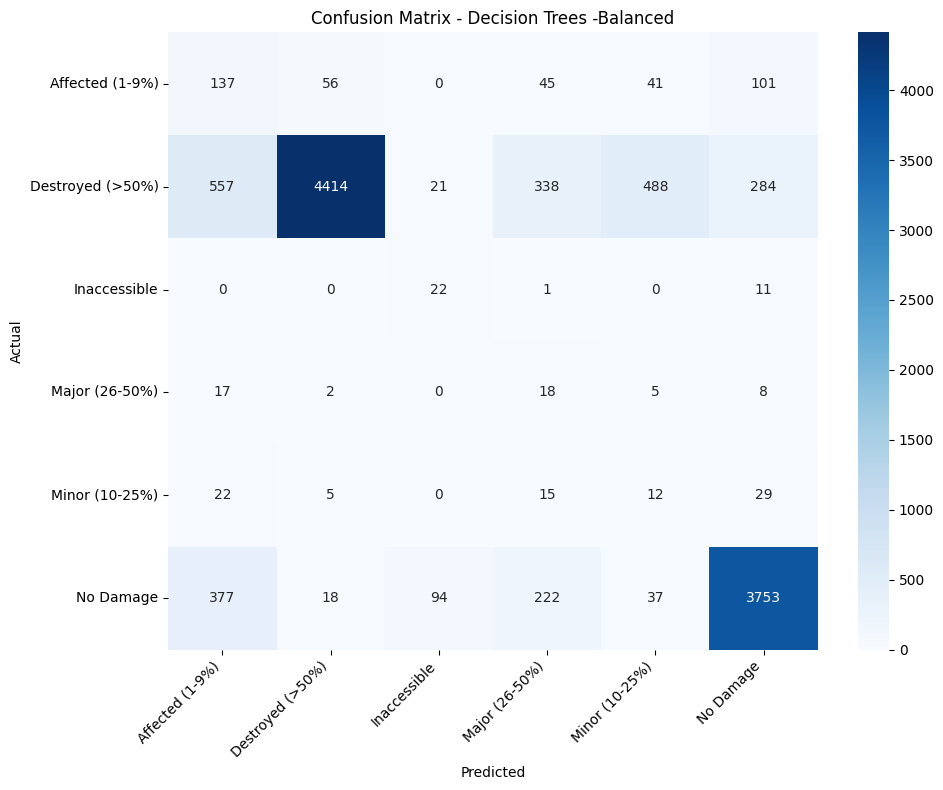

In [81]:
# Importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


#Splitting
attr_train_c5, attr_test_c5, target_train_c5, target_test_c5 = train_test_split(attr, target, test_size=0.2, random_state=6)


#C5
c50 = DecisionTreeClassifier(max_depth=8, random_state=42, class_weight='balanced')
c50.fit(attr_train_c5, target_train_c5)
target_pred_c5 = c50.predict(attr_test_c5)

#Evaluate
target_test_decoded = le_target.inverse_transform(target_test_c5)
target_pred_decoded = le_target.inverse_transform(target_pred_c5)

print("\nDecision Trees Classification Report:")
print(classification_report(target_test_decoded, target_pred_decoded))

#Confusion Matrix
cm_nb = confusion_matrix(target_test_decoded, target_pred_decoded, labels=le_target.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Trees -Balanced')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Using the C5 Decision Trees, we see that our model is 75% accurate. We can also see that most of our data either falls into "Destroyed", with "No Damage" coming at a close second. Other categories have less data

# ANN

Applying SMOTETomek to training data...

ANN Classification Report:
                  precision    recall  f1-score   support

 Affected (1-9%)       0.07      0.12      0.09       395
Destroyed (>50%)       0.93      0.64      0.76      6120
    Inaccessible       0.04      0.77      0.07        31
  Major (26-50%)       0.02      0.40      0.04        57
  Minor (10-25%)       0.02      0.12      0.03        86
       No Damage       0.77      0.67      0.72      4461

        accuracy                           0.63     11150
       macro avg       0.31      0.45      0.28     11150
    weighted avg       0.82      0.63      0.71     11150



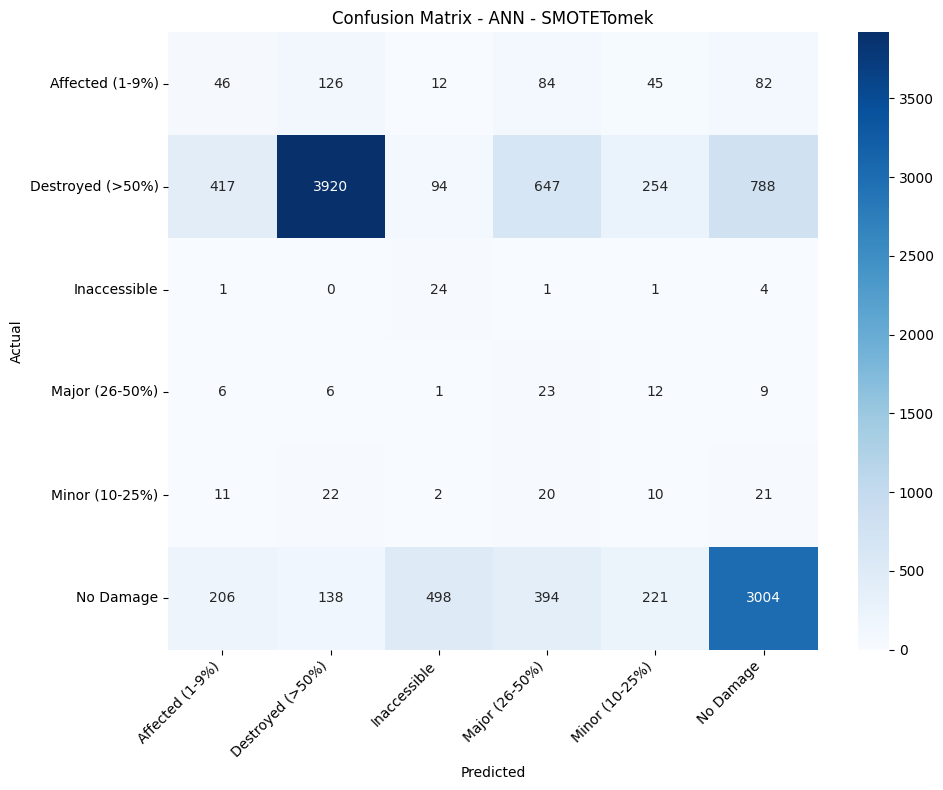

In [82]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

#Normalizing the data
scaler = StandardScaler()
attr_ann = pd.DataFrame(
    scaler.fit_transform(opt_attr.copy()),
    columns=opt_attr.columns
)

#Splitting the data
attr_train_ann, attr_test_ann, target_train_ann, target_test_ann = train_test_split(attr_ann, target, random_state=82, test_size=0.2)


print("Applying SMOTETomek to training data...")

from imblearn.combine import SMOTETomek
smote = SMOTETomek(random_state=42)
attr_train_res, target_train_res = smote.fit_resample(attr_train_ann, target_train_ann)

#ANN
model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=20000)
model.fit(attr_train_res, target_train_res)
target_pred_ann = model.predict(attr_test_ann)

#Evaluate
target_test_decoded = le_target.inverse_transform(target_test_ann)
target_pred_decoded = le_target.inverse_transform(target_pred_ann)

print("\nANN Classification Report:")
print(classification_report(target_test_decoded, target_pred_decoded))

#Confusion Matrix
cm_nb = confusion_matrix(target_test_decoded, target_pred_decoded, labels=le_target.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - ANN - SMOTETomek')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


We used SMOTE to balance out the results with ANN. Using the ANN method, we see that our model is 67% accurate. Like before, we can also see that most of our data into "Destroyed", with "No Damage" the second most. There is  less data for any other categories.

# Agentic Model
The Agentic model works using a few external technologies:
1. Anthropic's Claude LLM for generating Python code
2. E2B -  a secure sandbox for running AI generated code.
Basically, we instruct the LLM to do data analysis tasks on our data set via generating Python code. Then, we analyze the results of the code and send it back to the LLM for further generation/analysis. Ultimately, we do this in a series of steps starting with EDA, going to cleaning, and then model picking and running. Finally, we use an LLM call to summarize all the code that has been generate and run to determine the best model.

In [83]:
%pip install e2b-code-interpreter
%pip install anthropic
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [84]:
# This is the prompt that we will give to our agent.
eda_prompt = f"""You are a Python data analyst. Your job is to analyze the `California-Wildfire-Data.csv`
and generate a model to predict the damage done to houses based on the other features. The output of the Python code should
provide useful insights. Your first task is to do an Exploritory Data Analysis on the data. You can assume that the 
csv is accessible to you at `/home/user/California-Wildfire-Data.csv`. 

**Task**
For your first task, just load it and print the head.

Packages you are allowed to use:
- scikit-learn 
- pandas 
- numpy 
- seaborn 
- matplotlib

**CRITICAL**: Return only python code, your text response will be immediately sent to run in a secure sandbox."""

In [85]:
# Here, we send our first prompt to Claude, and it will generate our Python code for the EDA step.
from dotenv import load_dotenv
load_dotenv()
from anthropic import Anthropic
import os

client = Anthropic(
    api_key=os.environ.get("ANTHROPIC_API_KEY"), 
)

message = client.messages.create(
    max_tokens=10000,
    messages=[
        {
            "role": "user",
            "content": eda_prompt
           ,
        }
    ],
    model="claude-haiku-4-5-20251001",
)

In [86]:
eda_code = message.content[0].text.lstrip("```python").rstrip("```")
print(f"Proposed code: \n {eda_code}")

Proposed code: 
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load the data
df = pd.read_csv('/home/user/California-Wildfire-Data.csv')

# Print the head
print("First few rows of the dataset:")
print(df.head())



**Important note**
E2B Sandboxes only run for 5 minutes by default, so the following cells should be run sequentially within 5 minutes, as they require memory of previous code to properly perform.

In [87]:
from e2b_code_interpreter import Sandbox

sbx = Sandbox.create()
sbx.commands.run("pip install scikit-learn pandas numpy seaborn matplotlib")
with open("California-Wildfire-Data.csv", "rb") as file:
	sbx.files.write("/home/user/California-Wildfire-Data.csv", file)
result = sbx.run_code(eda_code)

In [88]:
eda_output = ""
for elm in result.logs.stdout:
    print(elm)
    eda_output += elm

First few rows of the dataset:
    _id          * Damage  * Street Number * Street Name  \
0  6092  Destroyed (>50%)                0       unknown   
1  6094  Destroyed (>50%)                0       unknown   
2  6165         No Damage                0       unknown   
3  6171  Destroyed (>50%)                0       unknown   
4  6172  Destroyed (>50%)                0       unknown   

  * Street Type (e.g. road, drive, lane, etc.) * City State * CAL FIRE Unit  \
0                                         Road    NaN    CA             FKU   
1                                         Road    NaN    CA             FKU   
2                                          NaN    NaN    CA             FKU   
3                                          NaN    NaN    CA             FKU   
4                                          NaN    NaN    CA             FKU   

   County * Incident Name  ... * Fence Attached to Structure APN (parcel)  \
0  Fresno           Creek  ...                      No F

In [89]:
# This is the prompt that we will give to our agent.
cleaning_prompt = f"""You are a Python data analyst. A Jupyter notebook cell has just been run to load in and do an EDA of `California-Wildfire-Data.csv`.
Based on the results of the code, please generate Python code to follow which will clean the data and report on what has been cleaned. Assume that your
code will run in the next Jupyter notebook cell.

**Task**
Generate Python code to clean the data described by the code and output below.

**Previous code block**
{eda_code}

**Output from that code**
{eda_output}

Packages you are allowed to use:
- scikit-learn 
- pandas 
- numpy 
- seaborn 
- matplotlib

**CRITICAL**: Return only python code, your text response will be immediately sent to run in a secure sandbox."""

message = client.messages.create(
    max_tokens=10000,
    messages=[
        {
            "role": "user",
            "content": cleaning_prompt
           ,
        }
    ],
    model="claude-haiku-4-5-20251001",
)

In [90]:
cleaning_code = message.content[0].text.lstrip("```python").rstrip("```")
print(f"Proposed code: \n {cleaning_code}")

Proposed code: 
 
# Data Cleaning Report
print("="*80)
print("DATA CLEANING REPORT FOR CALIFORNIA WILDFIRE DATA")
print("="*80)

# Check initial shape
print(f"\nInitial dataset shape: {df.shape}")

# Display missing values
print("\n1. MISSING VALUES ANALYSIS:")
print("-" * 80)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percent': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)
print(missing_df)

# Display data types
print("\n2. DATA TYPE ANALYSIS:")
print("-" * 80)
print(df.dtypes)

# Check for duplicates
print("\n3. DUPLICATE RECORDS:")
print("-" * 80)
duplicates = df.duplicated().sum()
print(f"Total duplicate rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Duplicates removed. New shape: {df.shape}")

# Check for ID c

In [91]:
result = sbx.run_code(cleaning_code)
cleaning_output = ""
for elm in result.logs.stdout:
    print(elm)
    cleaning_output += elm

DATA CLEANING REPORT FOR CALIFORNIA WILDFIRE DATA

Initial dataset shape: (55750, 33)

1. MISSING VALUES ANALYSIS:
--------------------------------------------------------------------------------
                                          Column  Missing_Count  \
5                                         * City          21250   
4   * Street Type (e.g. road, drive, lane, etc.)           3524   
27                         Site Address (parcel)           1018   
3                                  * Street Name            887   
22   * Patio Cover/Carport Attached to Structure              2   
21                         * Deck/Porch Elevated              1   

    Missing_Percent  
5         38.116592  
4          6.321076  
27         1.826009  
3          1.591031  
22         0.003587  
21         0.001794  

2. DATA TYPE ANALYSIS:
--------------------------------------------------------------------------------
_id                                               int64
* Damage           

In [92]:
# This is the prompt that we will give to our agent.
model_prompt = f"""You are a Python data analyst. EDA and Data Cleaning have just been run on our dataset in `California-Wildfire-Data.csv`.
Your job is to compare models based on their ability to predict Damage. You must generate Python code which should run each model and create
a comprehensive report based on the results, detailing which model should be used and how (which parameters)

**Task**
Based on the EDA and Data Cleaning Results, run each of the models below on the data to find the best at predicting damage based on the other features.
Your code should **not** generate any visualizations, nor should it take any longer than 3 minutes to run.

**Models**
- CART
- KNN
- Naive Bayes

**Previous code blocks**
{eda_code}
{cleaning_code}

**Output from that code**
{eda_output}
{cleaning_code}

Packages you are allowed to use:
- scikit-learn 
- pandas 
- numpy 
- seaborn 
- matplotlib

**CRITICAL**: Return only python code, your text response will be immediately sent to run in a secure sandbox."""

message = client.messages.create(
    max_tokens=10000,
    messages=[
        {
            "role": "user",
            "content": model_prompt
           ,
        }
    ],
    model="claude-haiku-4-5-20251001",
)

In [93]:
model_code = message.content[0].text.lstrip("```python").rstrip("```")
print(f"Proposed code: \n {model_code}")

Proposed code: 
 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('/home/user/California-Wildfire-Data.csv')

print("="*80)
print("MODEL COMPARISON REPORT: PREDICTING WILDFIRE DAMAGE")
print("="*80)

# Data Cleaning
print("\nPreparing data...")
initial_rows = len(df)
df = df.dropna(subset=['Latitude', 'Longitude'])

# Drop columns with >50% missing values
cols_to_drop = []
for col in df.columns:
    missing_percent = (df[col].isnull().sum() / len(df)) * 100
    if missing_percent > 50:
        cols_to_drop.append(col)
df = df.drop(columns=cols_to_drop)

# Fill NaN in 

In [94]:
result = sbx.run_code(model_code)
model_output = ""
for elm in result.logs.stdout:
    print(elm)
    model_output += elm

MODEL COMPARISON REPORT: PREDICTING WILDFIRE DAMAGE

Preparing data...

Dataset shape after cleaning: (52951, 34)
Target variable distribution:
* Damage
Destroyed (>50%)    30705
No Damage           22246
Name: count, dtype: int64

Final feature set: 9 features, 52951 samples

MODEL TRAINING AND EVALUATION

1. CART (Classification and Regression Trees)
--------------------------------------------------------------------------------

   R² Score: 0.6213
   RMSE: 0.9112
   MAE: 0.5329
   Cross-validation R² (5-fold): 0.6164
   Parameters: max_depth=10, min_samples_split=5, min_samples_leaf=2

2. KNN (K-Nearest Neighbors)
--------------------------------------------------------------------------------

   R² Score: 0.8013
   RMSE: 0.6601
   MAE: 0.2535
   Cross-validation R² (5-fold): 0.7834
   Optimal Parameters: n_neighbors=7, weights='distance'

3. Naive Bayes (Gaussian)
--------------------------------------------------------------------------------
   R² Score: 0.1110
   RMSE: 1.3962

In [95]:
summary_prompt = f"""You are a Python data analyst. You are receiving the results of a data analysis on comparing models, working with California
Wildfire data. Based on the code and output, generate a markdown report summarizing the findings. Be concise, and be sure to explain which model 
performed the best, and why.

**Task**
Generate a markdown summary of the Python data analysis below

**Previous code blocks**
{eda_code}
{cleaning_code}
{model_code}

**Output from that code**
{eda_output}
{cleaning_code}
{model_output}

**CRITICAL**: Return only the markdown report."""

message = client.messages.create(
    max_tokens=10000,
    messages=[
        {
            "role": "user",
            "content": summary_prompt
           ,
        }
    ],
    model="claude-haiku-4-5-20251001",
)

In [96]:
print(message.content[0].text)

# California Wildfire Damage Prediction: Model Comparison Report

## Executive Summary

A comparative analysis was conducted to identify the best machine learning model for predicting wildfire damage severity in California. Three models were evaluated: CART (Decision Tree), KNN (K-Nearest Neighbors), and Naive Bayes (Gaussian).

## Dataset Overview

- **Final Dataset Size:** 52,951 samples with 9 features
- **Target Variable:** Wildfire damage classification (Destroyed >50% vs. No Damage)
- **Data Cleaning:** Removed rows with missing geographic coordinates; eliminated columns with >50% missing values; filled categorical NaN values with 'Unknown'

## Model Performance Comparison

| Model | R² Score | RMSE | MAE | CV R² (5-fold) |
|-------|----------|------|-----|----------------|
| **KNN** | **0.8013** | **0.6601** | **0.2535** | **0.7834** |
| CART | 0.6213 | 0.9112 | 0.5329 | 0.6164 |
| Naive Bayes | 0.1110 | 1.3962 | 0.6498 | -0.0098 |

## Best Model: K-Nearest Neighbors (KNN)

### 